In [8]:
import warnings
import numpy as np
import gc
import json
import h5py
import threading
import time
import seaborn as sn
import pandas as pd

import tensorflow as tf
from keras.models import load_model
from keras.utils import Sequence
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.preprocessing.sequence import _remove_long_seq
from keras.models import Sequential
from keras.layers import Embedding, Input, Dense, Dropout, CuDNNLSTM, Bidirectional
from keras import metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

# training on 1080 Ti, you may want to adjust these for your own hardware
gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction=0.65, allow_growth=False)
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                        inter_op_parallelism_threads=16, allow_soft_placement=True, gpu_options=gpu_options)
session = tf.Session(config=config)
K.set_session(session)


In [9]:
def get_word_index():
    f = open('data/word_index.json')
    data = json.load(f)
    f.close()
    return data


def load_vocab():
    with open('data/word_index_2019.json') as json_data:
        return json.load(json_data)

    
def load_glove():
    glove = {}
    with open('data/glove.arxmliv.15B.300d.txt') as glove_data:
        for line in glove_data:
            items = line.split()
            key = items[0]
            glove[key] = np.asarray(items[1:], dtype='float32')
    return glove


def build_embedding_layer(with_input=False, maxlen=512, vocab_dim=300, mask_zero=True):
    print("-- loading word embeddings, this may take a couple of minutes...")
    index_dict = load_vocab()
    word_vectors = load_glove()
    # adding 1 to account for 0th index (for masking)
    n_symbols = len(index_dict) + 1
    print("-- known dictionary items: ", n_symbols)
    embedding_weights = np.zeros((n_symbols, vocab_dim))
    for word, index in index_dict.items():
        embedding_weights[index, :] = word_vectors[word]
    print("-- embeddings ")
    if not with_input:
        embedding_layer = Embedding(
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False, weights=[embedding_weights])
        return embedding_layer
    else:
        # define inputs here
        input_1 = Input(shape=(maxlen,), dtype='int32')
        embedding_layer = Embedding(
            weights=[embedding_weights],
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False)(input_1)
        return (embedding_layer, input_1)


In [10]:
# Input data is obtained via batch loading from HDF5
class DataGenerator(Sequence):
    def __init__(self, batch_size=128, mode="train", dim=512,
             n_classes=46, x_hf = None, y_hf = None, shuffle=True):
        'Initialization'
        self.x_hf = x_hf
        self.y_hf = y_hf
        self.mode = mode
        self.total_len = self.y_hf.shape[0]
        self.validation_len = int(np.ceil(0.1 * self.total_len))
        self.training_len = self.total_len - self.validation_len
        if self.mode == "validation":
            self.data_len = self.validation_len
            self.list_IDs = np.arange(self.training_len, self.total_len)
        else:
            self.data_len = self.training_len
            self.list_IDs = np.arange(0,self.training_len+1)
            
        self.dim = dim
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end() 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples,  dim)
        # Initialization
        X = np.empty((self.batch_size, self.dim), dtype=int)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.x_hf[ID]
            # Store class
            y[i] = self.y_hf[ID]
        
        return X, y
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

batch_size = 128
# Parameters
data_hf = h5py.File("data/statement_paragraphs_arxmliv_08_2019.hdf5", 'r')
generator_params = {
    'batch_size': batch_size,
    'n_classes': 46,
    'shuffle': False,
    'x_hf': data_hf['x_train'],
    'y_hf': data_hf['y_train']
}
# Generators
training_generator = DataGenerator(**generator_params)
validation_generator = DataGenerator(mode="validation", **generator_params)


In [11]:
# It takes X minutes to recompute, memoizing here for the 46 class variant:
# class_weights = compute_class_weight('balanced', np.unique(training_generator.y_hf), training_generator.y_hf)
# np.set_printoptions(precision=32, suppress=True)
# print(class_weights)
class_weights = [0.41149278888023,     0.7057244877771286,   3.9829870906107514,
 36.374054954547326,   11.892902773743046,   13.80218842868916,
  0.06770583774558957, 31.914481685860814,    5.063662428479154,
  0.9402773356164806,  10.419343112996348,    7.468410273301577,
 16.455819246257715,    0.9736470848601226,  45.38169981935378,
 49.34844832108397,     0.5689703684124646,  19.235229180986853,
 18.96762510456661,     2.494897996609856,    1.2315613896598328,
  3.982038288896814,   23.05413209027794,    39.18802985114313,
 44.29421208174715,     0.4550588490658705,   0.3176264217702254,
  4.007815626539546,    1.3989257586172257,  28.458457503298686,
  6.908286212483653,    6.805206663531961,    6.996028838881382,
  3.784637564176529,    0.17672347524556367,  7.361449047820426,
  0.5111017831551758,  12.082011214554875,    8.752362066781215,
  0.602249639517737,    1.6020207292277908,   8.091288609751567,
 33.713939045033776,    3.439557710409422,    0.31825111426082914,
 66.8882673746634    ]

maxlen = 512
# Preparing word embeddings
#embedding_layer = build_embedding_layer(maxlen=maxlen, mask_zero=False)

In [12]:
# BiLSTM Model Setup
n_classes = 46
layer_size = 128  # ~maxlen // 4


In [13]:
model_file = "confusion_bilstm%d_batch%d_cat%d_gpu" % (
    layer_size, batch_size, n_classes)

# Checkpoints: 1) save best model at epoch end, 2) stop early when metric stops improving
# checkpoint = ModelCheckpoint(model_file+"-checkpoint.h5",
#                              monitor='val_weighted_sparse_categorical_accuracy',
#                              verbose=1,
#                              save_best_only=True,
#                              mode='max')

# earlystop = EarlyStopping(monitor='val_weighted_sparse_categorical_accuracy',
#                           min_delta=0.001,
#                           patience=3,
                          
#                           restore_best_weights=True,
#                           verbose=0, mode='auto')


In [15]:
#from keras.models import load_model
model = load_model(model_file+"-checkpoint.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [16]:
print("Per-class test measures:")
y_pred = model.predict_classes(data_hf['x_test'], verbose=1, batch_size=batch_size)
print(classification_report(data_hf['y_test'], y_pred))

Per-class test measures:
4421424/4421424 [==============================] - 2055s 465us/step


/home/deyan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/deyan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.91      0.93      0.92    233584
           1       1.00      1.00      1.00    136198
           2       0.52      0.27      0.35     24132
           3       0.55      0.16      0.25      2642
           4       0.42      0.38      0.40      8081
           5       0.58      0.13      0.21      6963
           6       0.99      0.99      0.99   1419647
           7       0.39      0.01      0.02      3011
           8       0.52      0.01      0.02     18982
           9       0.60      0.78      0.68    102223
          10       0.52      0.31      0.39      9224
          11       0.52      0.04      0.08     12870
          12       0.64      0.43      0.52      5841
          13       0.38      0.03      0.05     98720
          14       0.35      0.20      0.25      2117
          15       0.44      0.57      0.50      1947
          16       0.82      0.85      0.84    168934
          17       0.68    

/home/deyan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
class_names=np.array(sorted([
    "abstract", "acknowledgement", "analysis", "application", "assumption",
    "background", "caption", "case", "claim", "conclusion", "condition",
    "conjecture", "contribution", "corollary", "data", "dataset",
    "definition", "demonstration", "description", "discussion", "example",
    "experiment", "fact", "future work", "implementation", "introduction",
    "lemma", "methods", "model", "motivation", "notation", "observation",
    "preliminaries", "problem", "proof", "property", "proposition",
    "question", "related work", "remark", "result", "simulation", "step",
    "summary", "theorem", "theory", ]))

np.set_printoptions(precision=2)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        annot = True
        print("Normalized confusion matrix")
    else:
        annot = False
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(50,40))
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=annot)

Confusion matrix, without normalization


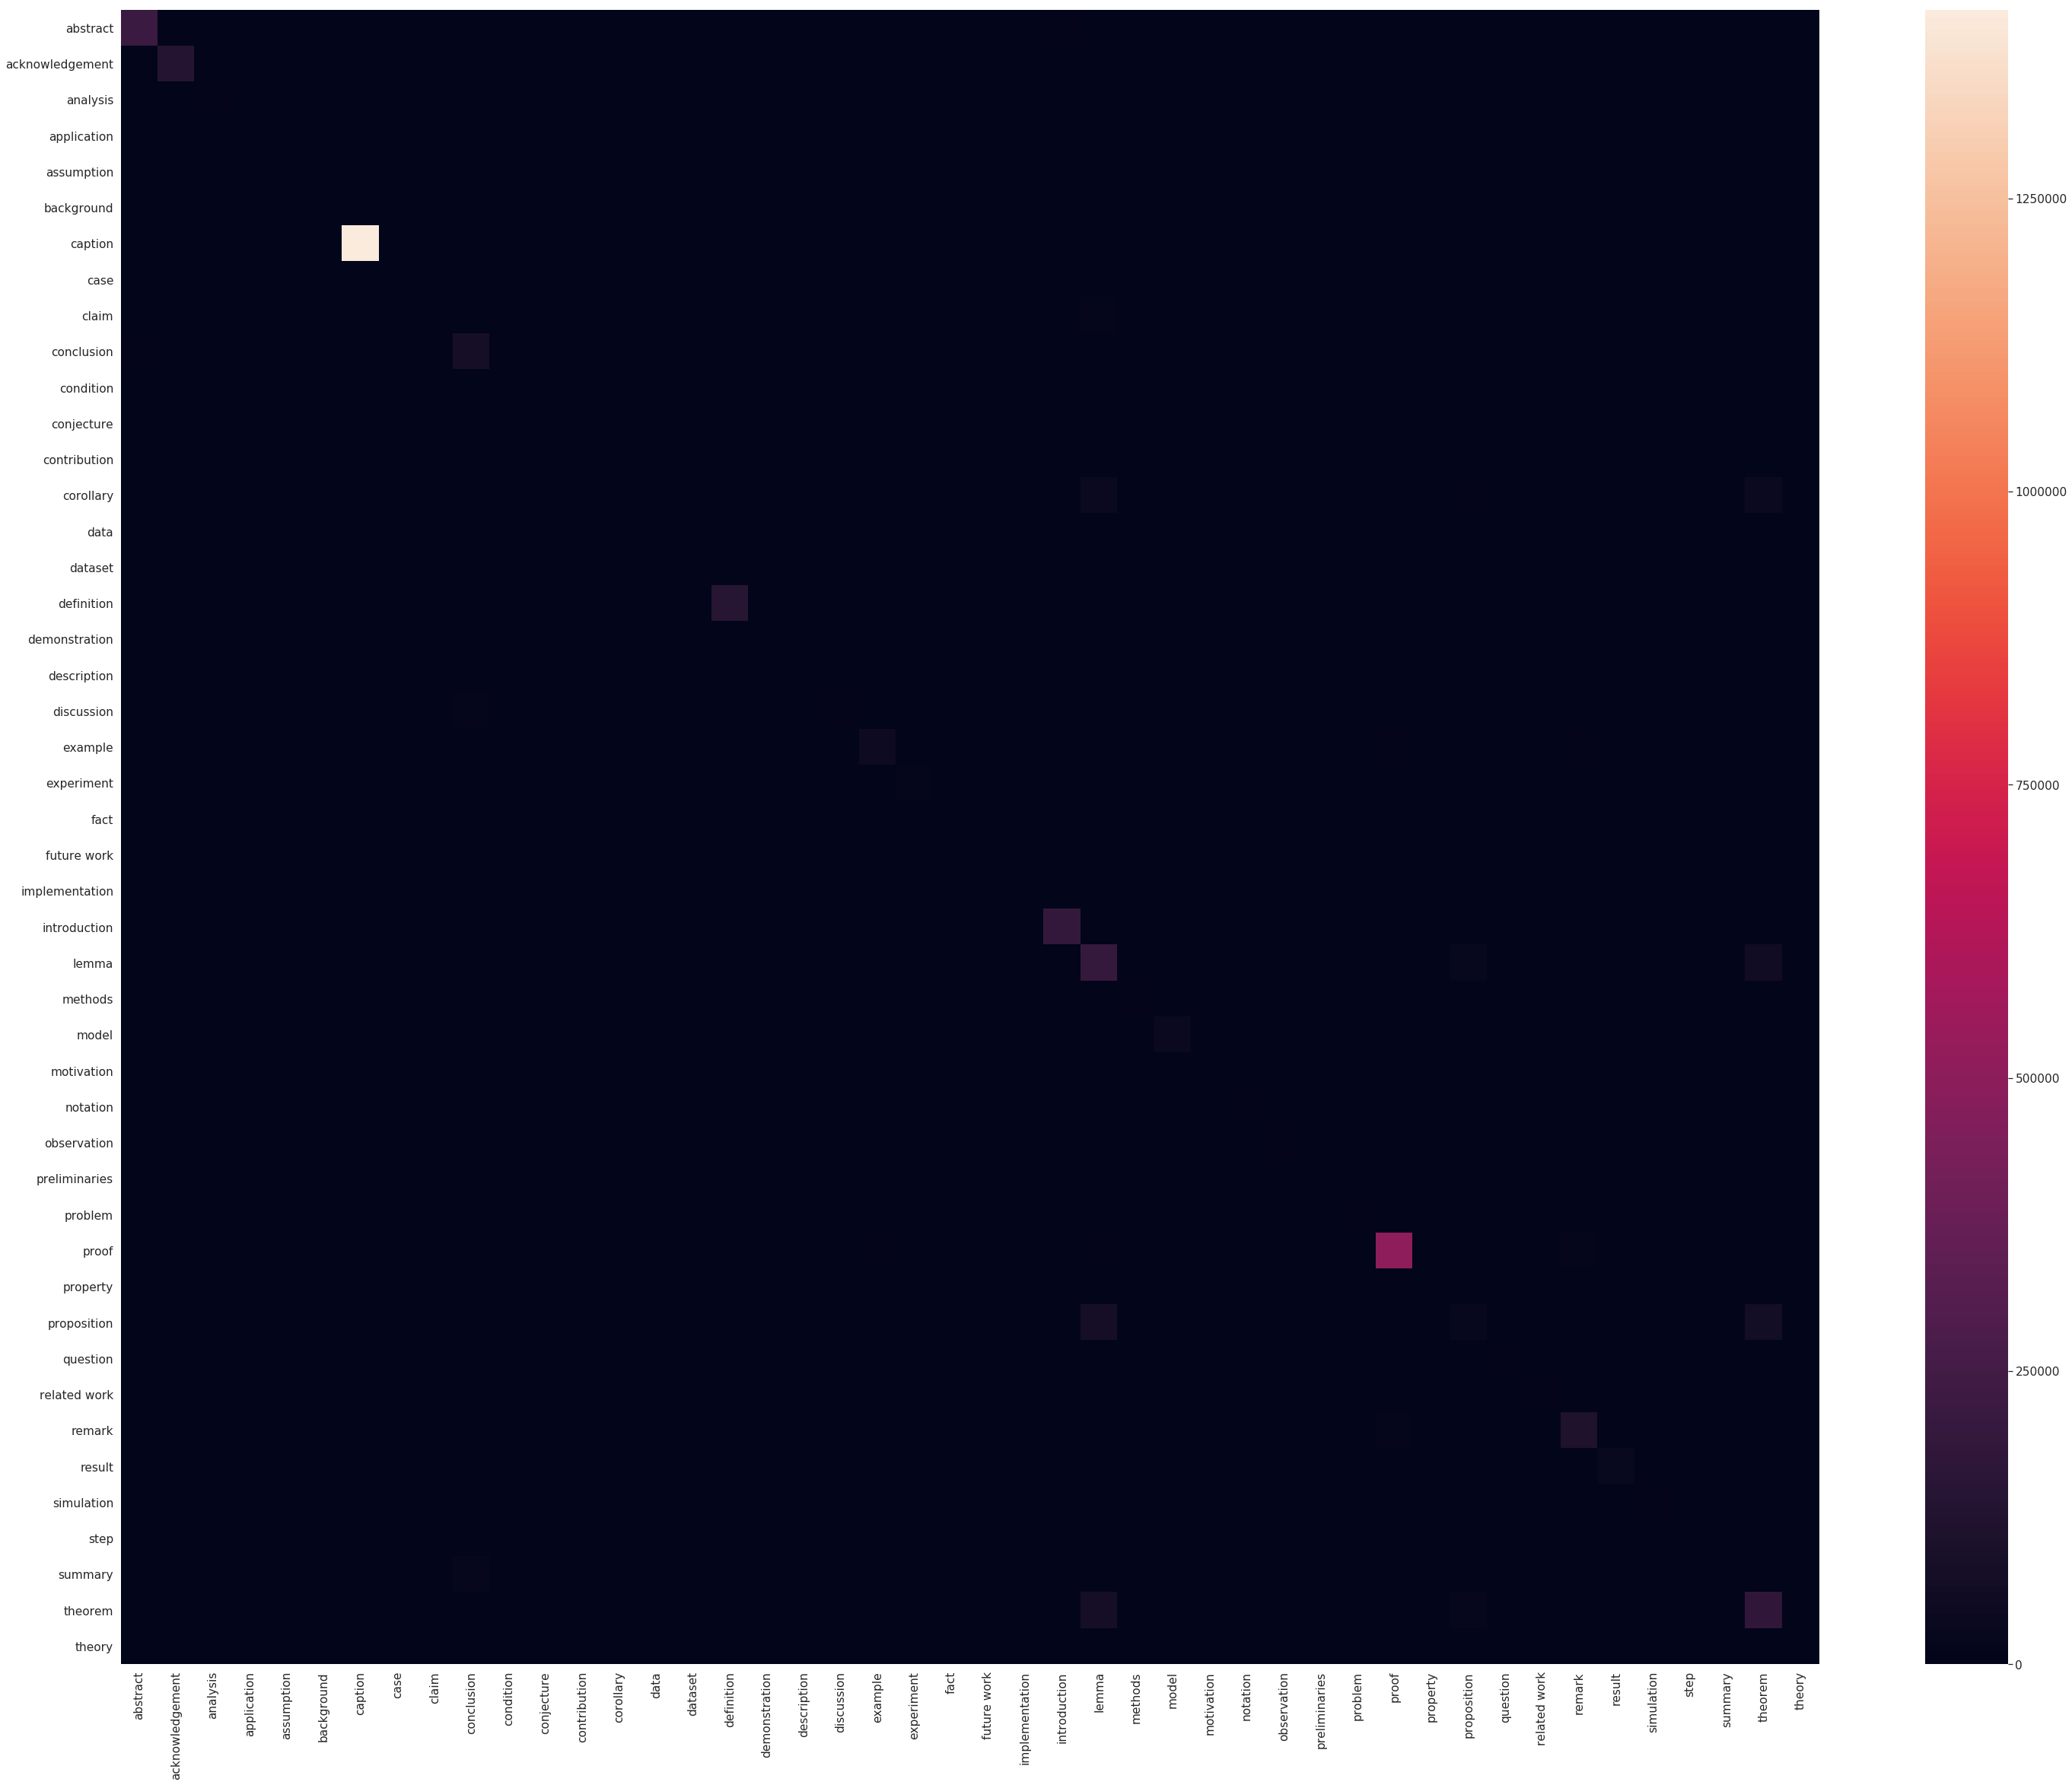

In [18]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


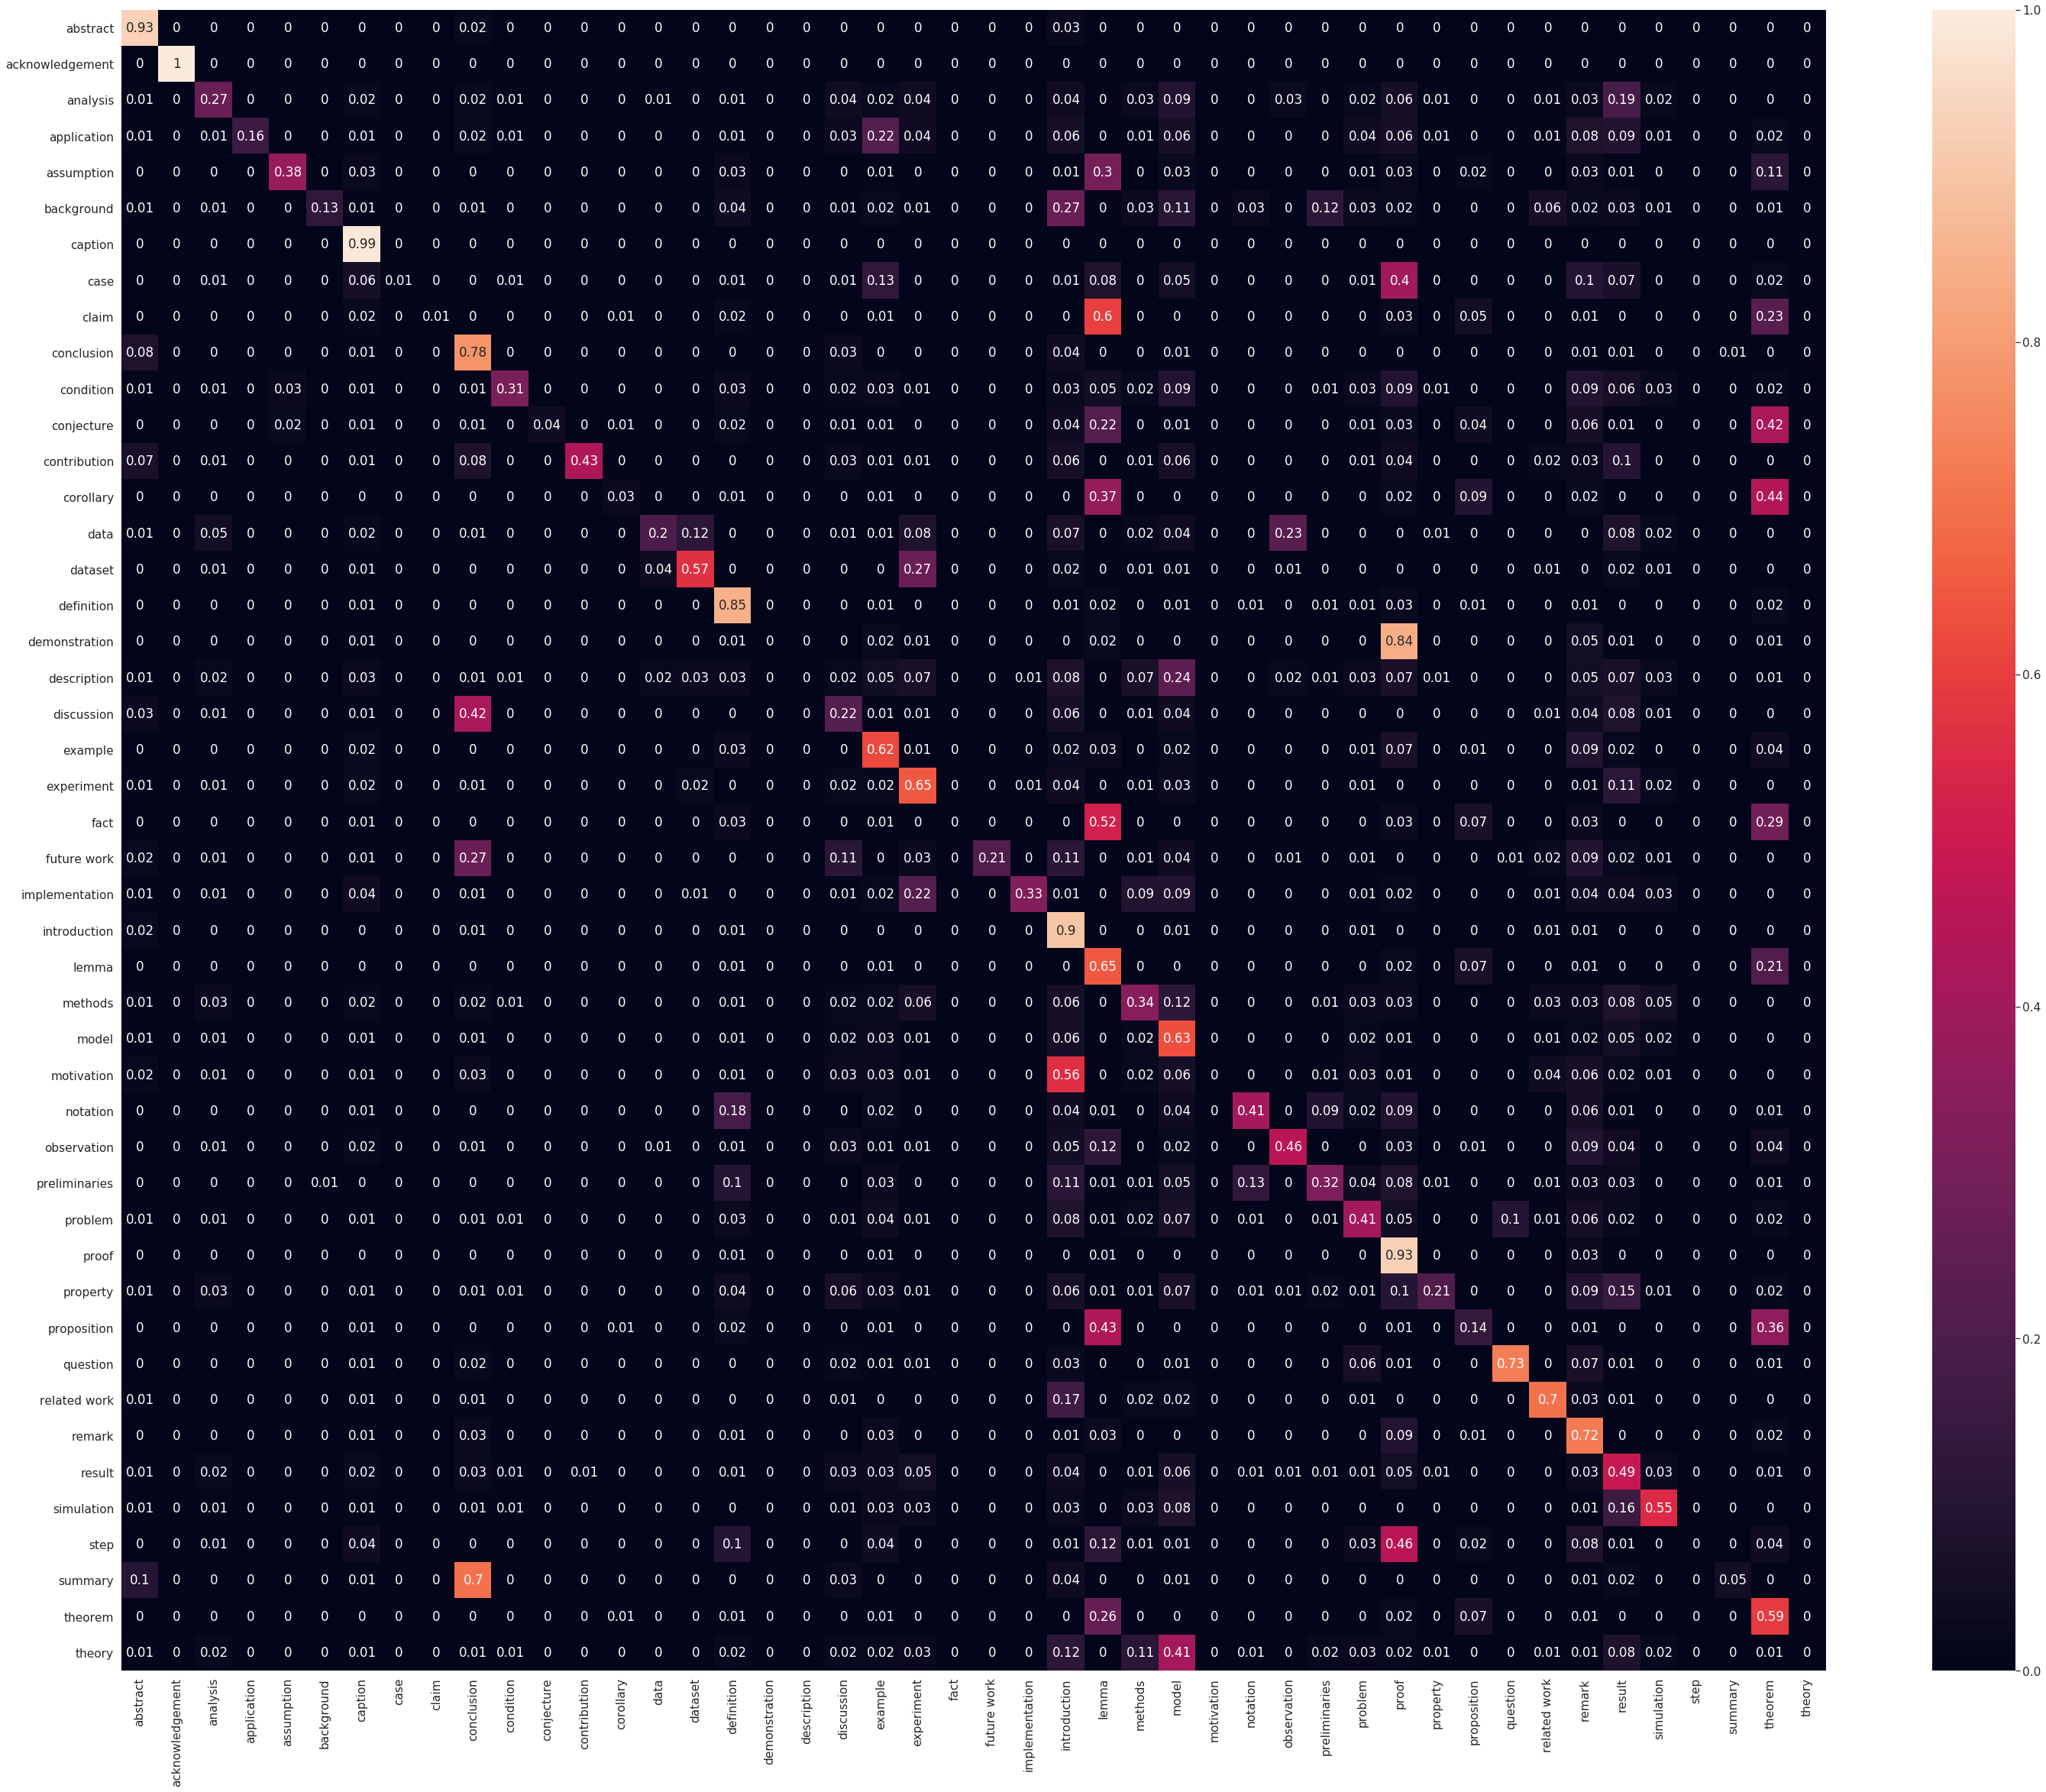

In [19]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Discussion

## Per-class test measures:

Using all 17.6 million statements for training (converged in X epochs), then testing on the unseen test set of 4.4 million entries:


## Confusion Matrix Analysis

Strong true signal:
 - acknowledgement - 1.0
 - caption - 0.99
 - abstract - 0.93
 - proof - 0.93
 - introduction - 0.9
 - definition - 0.85
 - conclusion - 0.78 (abstract 0.08)
 - question - 0.73 (0.07 remark + 0.06 problem)
 - remark - 0.72 (proof 0.09)
 - related work - 0.7 (0.17 introduction)

Mid-tier true signal:
 - lemma - 0.65 (theorem 0.21 + 0.07 proposition)
 - experiment - 0.65 (0.11 result)
 - model - 0.63 (0.06 intro, 0.05 result)
 - theorem - 0.59 (lemma 0.26)
 - example - 0.62 (0.07 proof + 0.09 remark)
 - dataset - 0.57 (0.27 experiment) 
 - simulation - 0.55 (0.16 result, 0.08 model)
 - result - 0.49 (0.05 experiment,model,proof)
 - observation - 0.46 (0.12 lemma + 0.09 remark)
 - contribution - 0.43 (0.1 result, 0.08 conclusion)
 - notation - 0.41 (0.18 definition + 0.9 preliminaries + 0.9 proof)
 - problem - 0.41 (0.1 question + 0.08 introduction + 0.07 model)

Strong confused signal:
 - demonstration - 0.84 proof
 - case - 0.4 proof + 0.13 example + 0.08 lemma
 - claim - 0.6 lemma + 0.23 theorem
 - conjecture - 0.42 theorem + 0.22 lemma + 0.06 remark
 - corollary - 0.37 lemma + 0.44 theorem
 - fact - 0.52 lemma + 0.29 theorem
 - motivation - 0.54 introduction
 - proposition - 0.43 lemma + 0.36 theorem + 0.14 self
 - summary - 0.7 conclusion, 0.1 abstract
 - theory - 0.41 model, 0.12 introduction, 0.11 methods
 
Weak Confused signal:
 - analysis - 0.27 self + 0.19 result
 - application - 0.16 self + 0.22 example
 - assumption - 0.38 self + 0.3 lemma + 0.11 theorem
 - background - 0.13 self + 0.27 introduction + 0.12 preliminaries + 0.11 model
 - condition - 0.31 self + 0.9 (remark, proof, model)
 - data - 0.2 self + 0.23 observation + 0.12 dataset
 - discussion - 0.42 conclusion +0.22 self
 - future work - 0.21 self + 0.27 conclusion + 0.11 discussion + 0.11 introduction + 0.09 remark
 - implementation - 0.33 self + 0.22 experiment + 0.09 methods + 0.09 model
 - methods - 0.34 self + 0.12 model + 0.08 result + 
 - preliminaries - 0.32 self + 0.13 notation + 0.11 introduction + 0.1 definition
 - property - 0.21 self + 0.15 result + 0.09 remark + 0.07 model
 - step - 0.46 proof, 0.12 lemma, 0.08 remark
 
Very noisy:
 - description - self 0, 0.24 model

----------------------------------------------------------------------------

I. **Strategy for a "confusion-free" classification scheme**
  - preserve strong true signal classes
    - acknowledgement, abstract, caption, proof, definition, introduction, question, remark, conclusion, related work 
  - merge together classes signals WHEN related semantically (theorem, lemma, proposition)
    - BIG "proposition" class is clearly motivated, all constituents misclassify to "theorem+lemma":
      - proposition = lemma + theorem + proposition + assumption + fact + conjecture + claim + corollary

----

Keep:
 - abstract - 0.93
 - acknowledgement - 1.0
 - caption - 0.99
 - conclusion = conclusion + summary + discussion + future work
 - definition - 0.85
 - example - 0.62
 - experiment = experiment + dataset + implementation
 - introduction = introduction + motivation + background
 - model = model + theory 
 - proof = proof + demonstration + case + step
 - proposition = lemma + theorem + proposition + assumption + fact + conjecture + claim + corollary
 - question - 0.73 (0.07 remark + 0.06 problem)
 - related work - 0.7 (0.17 introduction)
 - remark - 0.72 (proof 0.09)

Weaker keeps:
 - observation - observation + data
 - simulation - 0.55 (0.16 result, 0.08 model)
 - result - 0.49 (0.05 experiment,model,proof)
 - contribution - 0.43 (0.1 result, 0.08 conclusion)
 - notation - 0.41 (0.18 definition + 0.9 preliminaries + 0.9 proof)
 - problem - 0.41 (0.1 question + 0.08 introduction + 0.07 model)


Borderline Drop:
 - preliminaries - 0.32 self + 0.13 notation + 0.11 introduction + 0.1 definition
 - methods - 0.34 self + 0.12 model + 0.08 result + 0.06 experiment + 0.05 simulation
 - condition - 0.31 self + 0.9 (remark, proof, model)
Drop:
 - property
 - description
 - analysis
 - application



  **Final assembly**: 

| Class           | Additional Members     | Frequency |
|:----------------|:-----------------------|----------:|
| abstract        | -                      | 1,167,923 |
| acknowledgement | -                      |   680,991 |
| caption         | -                      | 7,098,238 |
| conclusion      | discussion, summary    |   855,734 |
| +               | future work            |         + |
| contribution    | -                      |   29,205  |
| definition      | -                      |   844,670 |
| example         | -                      |   390,229 |
| experiment      | dataset, implementation|   141,276 |
| introduction    | motivation, background | 1,107,816 |
| model           | theory                 |   350,727 |
| notation        | -                      |    69,567 |
| observation     | data                   |    81,210 |
| proof           | demonstration,         | 2,773,755 |
| +               | case, step             |         + |
| proposition     | assumption, claim, fact| 4,677,597 |
| +               | conjecture, corollary  |         + |
| +               | lemma, theorem         |         + |           
| problem         | -                      |   126,985 |
| question        | -                      |    39,777 |
| related work    | -                      |    54,910 |
| remark          | -                      |   797,994 |
| result          | -                      |   299,991 |
| simulation      | -                      |    59,396 |
| **TOTAL**       | -                      |**21,647,991** |


Frequencies reported is derived from the entire 22.1 million paragraph dataset, before any train/test splits. We preserve 21.7 million paragraphs in the reduced task, or 98% of the original data volume. The constrained classification set consists of 20 labels.